In [2]:
import argparse
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf
from keras import backend as K
from keras.layers import Input, Lambda, Conv2D
from keras.models import load_model, Model
from yolo_utils import read_classes, read_anchors, generate_colors, preprocess_image, draw_boxes, scale_boxes, preprocess_image_from_cv2
from yad2k.models.keras_yolo import yolo_head, yolo_boxes_to_corners, preprocess_true_boxes, yolo_loss, yolo_body
import imageio
import cv2
from skimage.transform import rescale, resize, downscale_local_mean
from PIL import Image

import time
from tensorflow.python.client import timeline

%matplotlib inline

Using TensorFlow backend.


**Important Note**: As you can see, we import Keras's backend as K. This means that to use a Keras function in this notebook, you will need to write: `K.function(...)`.

In [3]:
def yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = .6):
    """Filters YOLO boxes by thresholding on object and class confidence.
    
    Arguments:
    box_confidence -- tensor of shape (19, 19, 5, 1)
    boxes -- tensor of shape (19, 19, 5, 4)
    box_class_probs -- tensor of shape (19, 19, 5, 80)
    threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box
    
    Returns:
    scores -- tensor of shape (None,), containing the class probability score for selected boxes
    boxes -- tensor of shape (None, 4), containing (b_x, b_y, b_h, b_w) coordinates of selected boxes
    classes -- tensor of shape (None,), containing the index of the class detected by the selected boxes
    
    Note: "None" is here because you don't know the exact number of selected boxes, as it depends on the threshold. 
    For example, the actual output size of scores would be (10,) if there are 10 boxes.
    """
    
    box_scores = box_confidence * box_class_probs
   
    box_classes = K.argmax(box_scores, axis=-1)
    box_class_scores = K.max(box_scores, axis=-1)

    filtering_mask = box_class_scores >= threshold
    scores = tf.boolean_mask(box_class_scores, filtering_mask)
    boxes = tf.boolean_mask(boxes, filtering_mask)
    classes = tf.boolean_mask(box_classes, filtering_mask)
     
    return scores, boxes, classes

In [4]:
def iou(box1, box2):
    """Implement the intersection over union (IoU) between box1 and box2
    
    Arguments:
    box1 -- first box, list object with coordinates (x1, y1, x2, y2)
    box2 -- second box, list object with coordinates (x1, y1, x2, y2)
    """

    xi1 = max(box1[0], box2[0])
    yi1 = max(box1[1], box2[1])
    xi2 = min(box1[2], box2[2])
    yi2 = min(box1[3], box2[3])
    inter_area = max(xi2 - xi1, 0) * max(yi2 - yi1, 0)

    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - inter_area

    iou = inter_area / union_area

    return iou

In [5]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    """
    Applies Non-max suppression (NMS) to set of boxes
    
    Arguments:
    scores -- tensor of shape (None,), output of yolo_filter_boxes()
    boxes -- tensor of shape (None, 4), output of yolo_filter_boxes() that have been scaled to the image size (see later)
    classes -- tensor of shape (None,), output of yolo_filter_boxes()
    max_boxes -- integer, maximum number of predicted boxes you'd like
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (, None), predicted score for each box
    boxes -- tensor of shape (4, None), predicted box coordinates
    classes -- tensor of shape (, None), predicted class for each box
    
    Note: The "None" dimension of the output tensors has obviously to be less than max_boxes. Note also that this
    function will transpose the shapes of scores, boxes, classes. This is made for convenience.
    """
    
    max_boxes_tensor = K.variable(max_boxes, dtype='int32')     # tensor to be used in tf.image.non_max_suppression()
    K.get_session().run(tf.variables_initializer([max_boxes_tensor])) # initialize variable max_boxes_tensor
    
    # Use tf.image.non_max_suppression() to get the list of indices corresponding to boxes you keep
    nms_indices = tf.image.non_max_suppression(boxes, scores, max_boxes, iou_threshold)
    
    # K.gather() to select only nms_indices from scores, boxes and classes
    scores = K.gather(scores, nms_indices)
    boxes = K.gather(boxes, nms_indices)
    classes = K.gather(classes, nms_indices)
    
    return scores, boxes, classes

In [6]:
def yolo_eval(yolo_outputs, image_shape = (720., 1280.), max_boxes=10, score_threshold=.5, iou_threshold=.5): #score_threshold = 0.6
    """
    Converts the output of YOLO encoding (a lot of boxes) to your predicted boxes along with their scores, box coordinates and classes.
    
    Arguments:
    yolo_outputs -- output of the encoding model (for image_shape of (608, 608, 3)), contains 4 tensors:
                    box_confidence: tensor of shape (None, 19, 19, 5, 1)
                    box_xy: tensor of shape (None, 19, 19, 5, 2)
                    box_wh: tensor of shape (None, 19, 19, 5, 2)
                    box_class_probs: tensor of shape (None, 19, 19, 5, 80)
    image_shape -- tensor of shape (2,) containing the input shape, in this notebook we use (608., 608.) (has to be float32 dtype)
    max_boxes -- integer, maximum number of predicted boxes you'd like
    score_threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (None, ), predicted score for each box
    boxes -- tensor of shape (None, 4), predicted box coordinates
    classes -- tensor of shape (None,), predicted class for each box
    """
    
    # Retrieve outputs of the YOLO model
    box_confidence, box_xy, box_wh, box_class_probs = yolo_outputs

    # Convert boxes to be ready for filtering functions 
    boxes = yolo_boxes_to_corners(box_xy, box_wh)

    # Use one of the functions you've implemented to perform Score-filtering with a threshold of score_threshold
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, score_threshold)
    
    # Scale boxes back to original image shape.
    boxes = scale_boxes(boxes, image_shape)

    # Use one of the functions you've implemented to perform Non-max suppression with a threshold of iou_threshold
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes, iou_threshold)
    
    return scores, boxes, classes

<font color='blue'>
    
**Summary for YOLO**:
    
- Input image (608, 608, 3)
- The input image goes through a CNN, resulting in a (19,19,5,85) dimensional output. 
- After flattening the last two dimensions, the output is a volume of shape (19, 19, 425):
    - Each cell in a 19x19 grid over the input image gives 425 numbers. 
    - 425 = 5 x 85 because each cell contains predictions for 5 boxes, corresponding to 5 anchor boxes, as seen in lecture. 
    - 85 = 5 + 80 where 5 is because $(p_c, b_x, b_y, b_h, b_w)$ has 5 numbers, and and 80 is the number of classes we'd like to detect
- You then select only few boxes based on:
    - Score-thresholding: throw away boxes that have detected a class with a score less than the threshold
    - Non-max suppression: Compute the Intersection over Union and avoid selecting overlapping boxes
- This gives you YOLO's final output. 

In [7]:
#config = tf.ConfigProto()
#config.gpu_options.allow_growth = True
sess = K.get_session()

In [20]:
class_names = read_classes("model_data/coco_classes.txt")
anchors = read_anchors("model_data/yolo_anchors.txt")
image_shape = (2592., 4608.)#(720., 1280.) 

In [9]:
yolo_model = load_model("model_data/yolo.h5")

C:\Users\vedpk\Anaconda3\lib\site-packages\keras\engine\saving.py:269: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [10]:
yolo_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 608, 608, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 608, 608, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 608, 608, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 608, 608, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

**Reminder**: this model converts a preprocessed batch of input images (shape: (m, 608, 608, 3)) into a tensor of shape (m, 19, 19, 5, 85)

In [11]:
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))

In [12]:
start = time.time()
scores, boxes, classes = yolo_eval(yolo_outputs, image_shape)
end = time.time()
print(end - start, "seconds")

0.2938094139099121 seconds


In [13]:
def predict(sess, image_file, device_name):
    """
    Runs the graph stored in "sess" to predict boxes for "image_file". Prints and plots the preditions.
    
    Arguments:
    sess -- your tensorflow/Keras session containing the YOLO graph
    image_file -- name of an image stored in the "images" folder.
    
    Returns:
    out_scores -- tensor of shape (None, ), scores of the predicted boxes
    out_boxes -- tensor of shape (None, 4), coordinates of the predicted boxes
    out_classes -- tensor of shape (None, ), class index of the predicted boxes
    
    device -- device to use for eval. ('cpu' or 'gpu')
    
    Note: "None" actually represents the number of predicted boxes, it varies between 0 and max_boxes. 
    """
    
    if device_name == "gpu":
        device_name = "/gpu:0"
    else:
        device_name = "/cpu:0"

    # Preprocess your image

    image, image_data = preprocess_image("images/" + image_file, model_image_size = (608, 608))#model_image_size = (608, 608)
 
    # Run the session with the correct tensors and choose the correct placeholders in the feed_dict.
    # You'll need to use feed_dict={yolo_model.input: ... , K.learning_phase(): 0})
    start = time.time()
    with tf.device(device_name): #'/device:GPU:0'
        out_scores, out_boxes, out_classes = sess.run(yolo_eval(yolo_outputs, image_shape), feed_dict={yolo_model.input:image_data, K.learning_phase():0})
    end = time.time()
    print(end - start, "seconds")

    # Print predictions info
    print('Found {} boxes for {}'.format(len(out_boxes), image_file))
    # Generate colors for drawing bounding boxes.
    colors = generate_colors(class_names)
    # Draw bounding boxes on the image file
    draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)
       
    # Save the predicted bounding box on the image
    image.save(os.path.join("out", image_file), quality=90)
    # Display the results in the notebook
    output_image = imageio.imread(os.path.join("out", image_file))
    imshow(output_image)
    
    return out_scores, out_boxes, out_classes

1.1890208721160889 seconds
Found 2 boxes for tennis_ball (12).jpg
tennis ball 0.64 (1440, 838) (1567, 939)
person 0.75 (4034, 46) (4608, 1006)
Wall time: 2.77 s


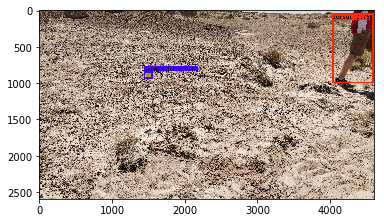

In [28]:
%%time
#for i in range(1,13):
out_scores, out_boxes, out_classes = predict(sess, "tennis_ball (12).jpg", device_name="cpu")

In [14]:
def predict_from_cv2(sess, image_file, device_name):
    """
    Runs the graph stored in "sess" to predict boxes for "image_file". Prints and plots the preditions.
    
    Arguments:
    sess -- your tensorflow/Keras session containing the YOLO graph
    image_file -- name of an image stored in the "images" folder.
    
    Returns:
    out_scores -- tensor of shape (None, ), scores of the predicted boxes
    out_boxes -- tensor of shape (None, 4), coordinates of the predicted boxes
    out_classes -- tensor of shape (None, ), class index of the predicted boxes
    
    device -- device to use for eval. ('cpu' or 'gpu')
    
    Note: "None" actually represents the number of predicted boxes, it varies between 0 and max_boxes. 
    """
    
    if device_name == "gpu":
        device_name = "/gpu:0"
    else:
        device_name = "/cpu:0"

    image_file = cv2.cvtColor(image_file,cv2.COLOR_BGR2RGB)
    image_file = Image.fromarray(image_file) ## cv2 to pil image
    # Preprocess your image
    image, image_data = preprocess_image_from_cv2(image_file, model_image_size = (608, 608))

    # Run the session with the correct tensors and choose the correct placeholders in the feed_dict.
    # You'll need to use feed_dict={yolo_model.input: ... , K.learning_phase(): 0})
    with tf.device(device_name): #'/device:GPU:0'
        out_scores, out_boxes, out_classes = sess.run(yolo_eval(yolo_outputs, image_shape), feed_dict={yolo_model.input:image_data, K.learning_phase():0})

    # Print predictions info
    ######print('Found {} boxes for {}'.format(len(out_boxes), "x"))
    # Generate colors for drawing bounding boxes.
    colors = generate_colors(class_names)
    # Draw bounding boxes on the image file
    draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)
       
    # Save the predicted bounding box on the image
    ####image.save(os.path.join("out", image_file), quality=90)
    # Display the results in the notebook
    ###output_image = imageio.imread(os.path.join("out", image_file))
    #plt.imshow(np.asarray(image_file))
    
    return image_file
    #return out_scores, out_boxes, out_classes

In [29]:
def StreamFile(src):
    """
    src - source file(string)
    """
    ar = np.array([])
    out = cv2.VideoWriter('outpy.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (1280,720))
    if (isinstance(src, str)):
        cap = cv2.VideoCapture(src)
        # Check if camera opened successfully
        if (cap.isOpened()== False): 
            print("Error opening video stream or file")
        i = 0
        # Read until video is completed
        length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))



        #When everything done, release the video capture object
        cap.release()
        out.release()
        # Closes all the frames
        cv2.destroyAllWindows()

In [30]:
StreamFile(src="images/IMG_3320.MOV")

sofa 0.51 (596, 409) (852, 694)
tennis ball 0.52 (445, 459) (492, 497)
sofa 0.67 (631, 382) (1179, 718)
person 0.77 (352, 149) (640, 701)
person 0.85 (841, 331) (1274, 717)
1
tennis ball 0.54 (446, 458) (493, 499)
sofa 0.69 (622, 386) (1180, 713)
person 0.76 (353, 154) (649, 699)
person 0.86 (844, 333) (1269, 713)
2
sofa 0.53 (600, 409) (852, 696)
tennis ball 0.61 (452, 460) (503, 504)
sofa 0.67 (619, 385) (1188, 713)
person 0.72 (348, 159) (648, 692)
person 0.83 (829, 331) (1280, 714)
3
sofa 0.54 (554, 399) (1149, 708)
sofa 0.56 (602, 406) (848, 696)
tennis ball 0.64 (454, 462) (502, 507)
person 0.75 (348, 156) (649, 699)
person 0.84 (836, 374) (1261, 718)
4
tennis ball 0.56 (457, 465) (503, 507)
person 0.77 (355, 156) (653, 705)
person 0.84 (833, 381) (1263, 718)
5
tennis ball 0.56 (459, 466) (505, 507)
person 0.73 (354, 159) (657, 708)
person 0.83 (838, 383) (1262, 720)
6
tennis ball 0.54 (462, 468) (506, 506)
person 0.73 (357, 161) (654, 707)
person 0.85 (839, 378) (1259, 720)
7
te

KeyboardInterrupt: 

In [17]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5394528765306021050
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3168377241
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10708634544412328776
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]
